In [1]:
import pandas as pd

In [3]:
CoT = True
if CoT:
    llm_outputs = pd.read_csv(f'transcripts/cot_llm_output_final.csv', delimiter='|')
else:
    llm_outputs = pd.read_csv(f'transcripts/LLM_outputs_final.csv')

In [10]:
''' LLM features concering Management '''
no_transparency = [
    'evasiveness', 'vagueness', 'positive_sentiment'
    ]

no_awareness = [
    'macroeconomic', 'industry_positioning', 'operational_trends', 'asset_quality',
    ]

openess = [
    'language_accessibility_presentation', 'debt_leverage_stress', 'recovery_strategies', 'legal_issues', 'optimistic', 'responsiveness'
    ]


''' LLM features and emotions concering Analysts '''
emotional_concerns = [
    'analyst_concerns', 'anger_analysts', 'embarrassment_analysts', 'remorse_analysts'
    ]

true_negativity = [
    'disapproval_analysts', 'fear_analysts', 'sadness_analysts'
    ]

true_satisfaction = [
    'analyst_satisfaction', 'optimism_analysts', 'joy_analysts', 
    ]


''' Emotions concering Management '''
constructive_engagement = [
    'excitement', 'relief', 'anger', 'fear', 'embarrassment', 'admiration', 'realization'
    ]
ambiguous_emotions = [
    'disappointment', 'sadness', 'remorse', 'confusion', 'surprise', 'pride', 'joy', 'approval', 'desire'
    ]

In [11]:
from sklearn.decomposition import PCA

def pca_feature_groups(df, features, n_components=None):
    # Standardize the features
    df = df[features]
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(df)

    # Extract loading matrix
    loadings = pd.DataFrame(pca.components_.T, index=features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    
    # Group features by dominant PC
    feature_groups = {}
    for feature in loadings.index:
        dominant_pc = loadings.loc[feature].abs().idxmax()
        feature_groups.setdefault(dominant_pc, []).append(feature)

    return feature_groups, loadings

df = llm_outputs.copy()

# Management
mgmt_pca_groups, mgmt_loadings = pca_feature_groups(df, no_transparency + no_awareness + openess, n_components=2)
print(mgmt_pca_groups)
mgmt_pca1 = mgmt_loadings['PC1'].sort_values(ascending=False)
mgmt_pca2 = mgmt_loadings['PC2'].sort_values(ascending=False)
print(mgmt_pca1)
print(mgmt_pca2)


# Analysts
analyst_pca_groups, analyst_loadings = pca_feature_groups(df, emotional_concerns + true_negativity + true_satisfaction, n_components=2)
print(analyst_pca_groups)

# Emotions
emotions_pca_groups, emotions_loadings = pca_feature_groups(df, constructive_engagement + ambiguous_emotions, n_components=2)
print(emotions_pca_groups)


{'PC1': ['evasiveness', 'vagueness', 'positive_sentiment', 'operational_trends', 'asset_quality', 'recovery_strategies', 'optimistic'], 'PC2': ['macroeconomic', 'industry_positioning', 'language_accessibility_presentation', 'debt_leverage_stress', 'legal_issues', 'responsiveness']}
recovery_strategies                    0.439164
operational_trends                     0.388126
industry_positioning                   0.300168
optimistic                             0.279525
positive_sentiment                     0.261060
language_accessibility_presentation    0.235206
legal_issues                           0.095433
responsiveness                         0.081392
debt_leverage_stress                   0.060736
asset_quality                         -0.200947
evasiveness                           -0.269104
macroeconomic                         -0.301283
vagueness                             -0.376557
Name: PC1, dtype: float64
optimistic                             0.219430
positive_sentiment 

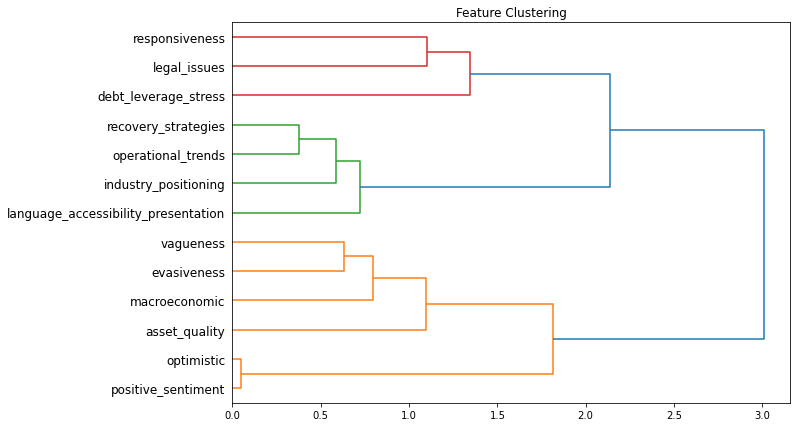

{1: ['evasiveness', 'vagueness', 'positive_sentiment', 'macroeconomic', 'asset_quality', 'optimistic'], 2: ['industry_positioning', 'operational_trends', 'language_accessibility_presentation', 'recovery_strategies'], 3: ['debt_leverage_stress', 'legal_issues', 'responsiveness']}


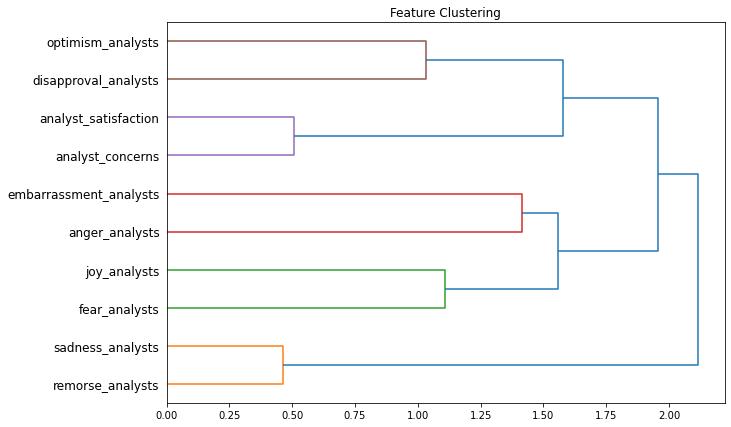

{4: ['analyst_concerns', 'analyst_satisfaction'], 3: ['anger_analysts', 'embarrassment_analysts'], 1: ['remorse_analysts', 'sadness_analysts'], 5: ['disapproval_analysts', 'optimism_analysts'], 2: ['fear_analysts', 'joy_analysts']}


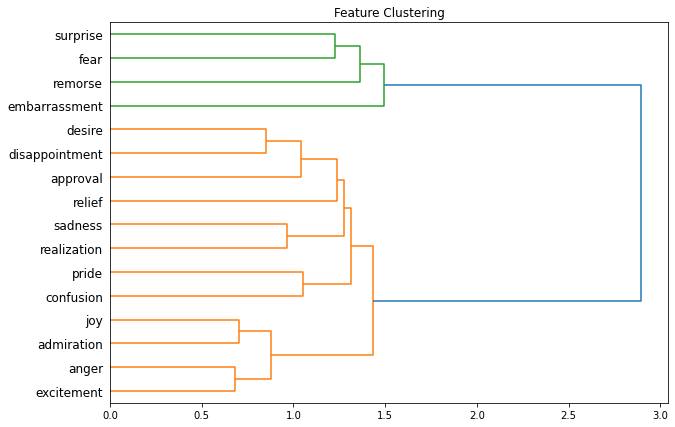

{1: ['excitement', 'relief', 'anger', 'admiration', 'realization', 'disappointment', 'sadness', 'confusion', 'pride', 'joy', 'approval', 'desire'], 2: ['fear', 'embarrassment', 'remorse', 'surprise']}


In [12]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

def cluster_features(df, features, method='ward', threshold=1.5):
    # Compute correlation matrix
    corr_matrix = df[features].corr().abs()

    # Perform hierarchical clustering
    linkage_matrix = linkage(corr_matrix, method=method)

    # Plot dendrogram (optional for visualization)
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=features, orientation='right')
    plt.title('Feature Clustering')
    plt.show()

    # Create clusters based on a threshold
    clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    clustered_features = {}
    for i, cluster in enumerate(clusters):
        clustered_features.setdefault(cluster, []).append(features[i])
    
    return clustered_features

# Management
clustered_features = cluster_features(df, no_transparency + no_awareness + openess, threshold=2)
print(clustered_features)

# Analysts
clustered_features = cluster_features(df, emotional_concerns + true_negativity + true_satisfaction, threshold=1.5)
print(clustered_features)

# Emotions
clustered_features = cluster_features(df, constructive_engagement + ambiguous_emotions, threshold=1.5)
print(clustered_features)


In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def kmeans_feature_groups(df, features, n_clusters=3):
    # Transpose feature matrix for clustering
    feature_matrix = df[features].T

    # Standardize the feature values
    #standardized_features = StandardScaler().fit_transform(feature_matrix)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(feature_matrix)

    # Group features by cluster
    clusters = kmeans.labels_
    clustered_features = {}
    for i, cluster in enumerate(clusters):
        clustered_features.setdefault(cluster, []).append(features[i])

    return clustered_features

# Management
clustered_features = kmeans_feature_groups(df, no_transparency + no_awareness + openess, n_clusters=2)
print(clustered_features)

# Analysts
clustered_features = kmeans_feature_groups(df, emotional_concerns + true_negativity + true_satisfaction, n_clusters=2)
print(clustered_features)

# Emotions
clustered_features = kmeans_feature_groups(df, constructive_engagement + ambiguous_emotions, n_clusters=2)
print(clustered_features)


{0: ['evasiveness', 'vagueness', 'macroeconomic', 'industry_positioning', 'operational_trends', 'asset_quality', 'language_accessibility_presentation', 'recovery_strategies', 'responsiveness'], 1: ['positive_sentiment', 'debt_leverage_stress', 'legal_issues', 'optimistic']}
{1: ['analyst_concerns', 'analyst_satisfaction'], 0: ['anger_analysts', 'embarrassment_analysts', 'remorse_analysts', 'disapproval_analysts', 'fear_analysts', 'sadness_analysts', 'optimism_analysts', 'joy_analysts']}
{1: ['excitement', 'relief', 'anger', 'fear', 'embarrassment', 'sadness', 'remorse', 'confusion', 'surprise', 'pride', 'joy', 'desire'], 0: ['admiration', 'realization', 'disappointment', 'approval']}


In [14]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

def supervised_pca(df, features, recovery_rate, n_components=1):
    """
    Performs supervised PCA where principal components are informed by the relationship
    between features and the recovery rate.

    Args:
        df (pd.DataFrame): The dataframe containing the features and target.
        features (list): List of feature column names.
        recovery_rate (str): Name of the recovery rate column.
        n_components (int): Number of principal components to compute.

    Returns:
        np.array: Scores of the supervised principal components.
        np.array: Weights (loadings) of the components.
    """
    # Standardize features and target
    scaler = StandardScaler()
    standardized_features = df[features]
    standardized_target = df[['RR']].values

    # Compute covariance of features with the recovery rate
    cov_matrix = np.dot(standardized_features.T, standardized_target).flatten()

    # Adjust features based on covariance with recovery rate
    adjusted_features = standardized_features * cov_matrix

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(adjusted_features)
    
    # Extract components and weights
    scores = pca.transform(adjusted_features)
    weights = pca.components_[0] / np.sum(np.abs(pca.components_[0]))  # Normalize weights

    return scores.flatten(), weights


In [9]:
# Management Cluster 0
management_cluster_0 = ['evasiveness', 'vagueness', 'positive_sentiment']

# Perform supervised PCA
df['Management_Cluster_0_Supervised_Score'], management_cluster_0_weights = supervised_pca(
    df, management_cluster_0, recovery_rate='Recovery_Rate'
)

print("Management Cluster 0 Weights:", dict(zip(management_cluster_0, management_cluster_0_weights)))

# Management Cluster 1
management_cluster_1 = ['language_accessibility_presentation', 'debt_leverage_stress', 'recovery_strategies', 'legal_issues', 'optimistic']

# Perform supervised PCA
df['Management_Cluster_1_Supervised_Score'], management_cluster_1_weights = supervised_pca(
    df, management_cluster_1, recovery_rate='Recovery_Rate'
)

print("Management Cluster 1 Weights:", dict(zip(management_cluster_1, management_cluster_1_weights)))

Management Cluster 0 Weights: {'evasiveness': -0.43355715594062355, 'vagueness': -0.5185442848597963, 'positive_sentiment': 0.047898559199580124}
Management Cluster 1 Weights: {'language_accessibility_presentation': -0.33423199101604933, 'debt_leverage_stress': -0.07017741086431892, 'recovery_strategies': -0.483304124751234, 'legal_issues': -0.0893040881570334, 'optimistic': -0.02298238521136434}
